<a href="https://colab.research.google.com/github/abhaynathk/Data_engineering_UseCase_assignment/blob/master/Usecase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd

In [31]:
!pip install pyspark

In [32]:
!pip install textblob

In [33]:

!pip install dash plotly pandas

In [34]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import (
    StructType, StructField, StringType,
    IntegerType, TimestampType
)
from pyspark.sql.functions import col, to_timestamp, udf, count, avg
from pyspark.sql import functions as F
import datetime
import random
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerFeedbackAnalysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Define schema for feedback data
feedback_schema = StructType([
    StructField("Customer_ID", StringType(), False),
    StructField("Feedback_Channel", StringType(), False),
    StructField("Rating", IntegerType(), False),
    StructField("Comment", StringType(), True),
    StructField("Date", TimestampType(), False)
])

In [36]:
def generate_spark_data(num_records=2000):
    """Generate sample data in Spark"""
    channels = ["Email", "Social Media", "Survey","news","Live chat","Interview"]
    comments = ["Too many bugs in the app....", "Too many ads on the platform....", "Love the new updates!", "Fantastic i love it !", "Horrible service to slow!", "Will be recommend !","I faced issues with payment.","Product is overpriced.","I received wrong item."]

    data = []
    current_date = datetime.datetime.now()

    for _ in range(num_records):
        data.append((
            f"C{random.randint(10000, 99999)}",
            random.choice(channels),
            random.randint(1, 5),
            random.choice(comments),
            (current_date - datetime.timedelta(days=random.randint(0, 30)))
        ))

    # Create Spark DataFrame
    return spark.createDataFrame(data, ["Customer_ID", "Feedback_Channel", "Rating", "Comment", "Date"])

# Generate the Spark DataFrame
spark_df = generate_spark_data(1000)
spark_df.show(5)


+-----------+----------------+------+--------------------+--------------------+
|Customer_ID|Feedback_Channel|Rating|             Comment|                Date|
+-----------+----------------+------+--------------------+--------------------+
|     C97616|          Survey|     5|Too many ads on t...|2024-10-30 11:14:...|
|     C67875|          Survey|     3| Will be recommend !|2024-10-09 11:14:...|
|     C79280|    Social Media|     2|Too many bugs in ...|2024-10-11 11:14:...|
|     C43626|            news|     2|Product is overpr...|2024-11-04 11:14:...|
|     C58986|       Interview|     2|Too many ads on t...|2024-10-26 11:14:...|
+-----------+----------------+------+--------------------+--------------------+
only showing top 5 rows



In [37]:
def spark_to_pandas(spark_df):
    """Convert Spark DataFrame to Pandas DataFrame"""
    try:
        pandas_df = spark_df.toPandas()
        print(f"Successfully converted {len(pandas_df)} records to pandas DataFrame")
        return pandas_df
    except Exception as e:
        print(f"Error converting to pandas: {e}")
        return None

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_to_pandas(spark_df.limit(1000))
print(pandas_df.head())

Successfully converted 1000 records to pandas DataFrame
  Customer_ID Feedback_Channel  Rating                           Comment  \
0      C97616           Survey       5  Too many ads on the platform....   
1      C67875           Survey       3               Will be recommend !   
2      C79280     Social Media       2      Too many bugs in the app....   
3      C43626             news       2            Product is overpriced.   
4      C58986        Interview       2  Too many ads on the platform....   

                        Date  
0 2024-10-30 11:14:52.432211  
1 2024-10-09 11:14:52.432211  
2 2024-10-11 11:14:52.432211  
3 2024-11-04 11:14:52.432211  
4 2024-10-26 11:14:52.432211  


In [43]:

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_data(df):
    """Clean the feedback comments."""

    # 1. Handle missing values
    df['Comment'] = df['Comment'].fillna('No Comment')

    # 2. Remove unnecessary characters, convert to lowercase, and strip extra spaces
    df['Comment'] = df['Comment'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Keep alphanumeric and spaces only
    df['Comment'] = df['Comment'].str.lower().str.strip()

    # 3. Correct spelling using TextBlob
    df['Comment'] = df['Comment'].apply(lambda x: str(TextBlob(x).correct()) if x != "No Comment" else x)

    # 4. Remove extra whitespaces
    df['Comment'] = df['Comment'].replace(r'\s+', ' ', regex=True)

    # 5. Remove stopwords
    df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]) if x != "No Comment" else x)

    # 6. Lemmatize words (optional, requires a lemmatizer if desired)
    # Uncomment the following lines if lemmatization is needed
    # from nltk.stem import WordNetLemmatizer
    # nltk.download('wordnet')
    # lemmatizer = WordNetLemmatizer()
    # df['Comment'] = df['Comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]) if x != "No Comment" else x)

    return df

# Clean the data
pandas_df = clean_data(pandas_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [44]:
from pyspark.sql.functions import pandas_udf
def analyze_sentiment(comment):
    """Analyze sentiment of the comment with improved handling."""
    if not comment or comment.strip() == "":  # Handle missing or empty comments
        return 'Neutral'

    analysis = TextBlob(comment)
    polarity = analysis.sentiment.polarity

    # Classify based on polarity score
    if polarity > 0.5:
        return 'Strongly Positive'
    elif polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    elif polarity < -0.5:
        return 'Strongly Negative'
    else:
        return 'Negative'

# Using pandas UDF for batch processing
@pandas_udf(StringType())
def sentiment_pandas_udf(comments: pd.Series) -> pd.Series:
    return comments.apply(analyze_sentiment)

# Perform sentiment analysis with pandas UDF
spark_df = spark_df.withColumn("Sentiment", sentiment_pandas_udf(col("Comment")))

In [45]:
def perform_analysis(pandas_df):
    """Perform basic analysis on the pandas DataFrame"""
    if pandas_df is None:
        print("No data available for analysis")
        return None

    analysis = {
        'total_records': len(pandas_df),
        'channel_distribution': pandas_df['Feedback_Channel'].value_counts().to_dict(),
        'average_rating': pandas_df['Rating'].mean(),
        'rating_distribution': pandas_df['Rating'].value_counts().sort_index().to_dict()
    }

    return analysis

# Perform analysis on the processed Pandas DataFrame
analysis = perform_analysis(pandas_df)
if analysis:
    print("\nAnalysis Results:")
    for key, value in analysis.items():
        print(f"{key}: {value}")


Analysis Results:
total_records: 1000
channel_distribution: {'Live chat': 191, 'news': 172, 'Survey': 169, 'Email': 168, 'Interview': 152, 'Social Media': 148}
average_rating: 2.974
rating_distribution: {1: 204, 2: 195, 3: 213, 4: 199, 5: 189}


+----------------+------------------+
|Feedback_Channel|    Average_Rating|
+----------------+------------------+
|            news|3.0930232558139537|
|       Interview|3.0197368421052633|
|           Email| 3.005952380952381|
|          Survey|2.9585798816568047|
|    Social Media| 2.885135135135135|
|       Live chat| 2.884816753926702|
+----------------+------------------+

+----------------+-----------------+-----+
|Feedback_Channel|        Sentiment|Count|
+----------------+-----------------+-----+
|           Email|         Negative|   20|
|           Email|          Neutral|   54|
|           Email|         Positive|   57|
|           Email|Strongly Negative|   17|
|           Email|Strongly Positive|   20|
|       Interview|         Negative|   17|
|       Interview|          Neutral|   49|
|       Interview|         Positive|   45|
|       Interview|Strongly Negative|   19|
|       Interview|Strongly Positive|   22|
|       Live chat|         Negative|   16|
|       Live chat

<ipython-input-46-8913415c4890>:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




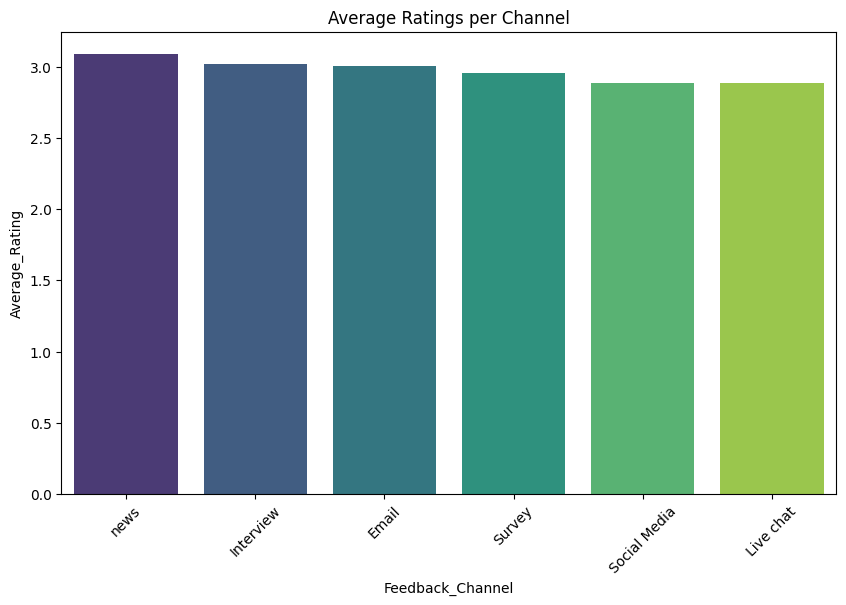

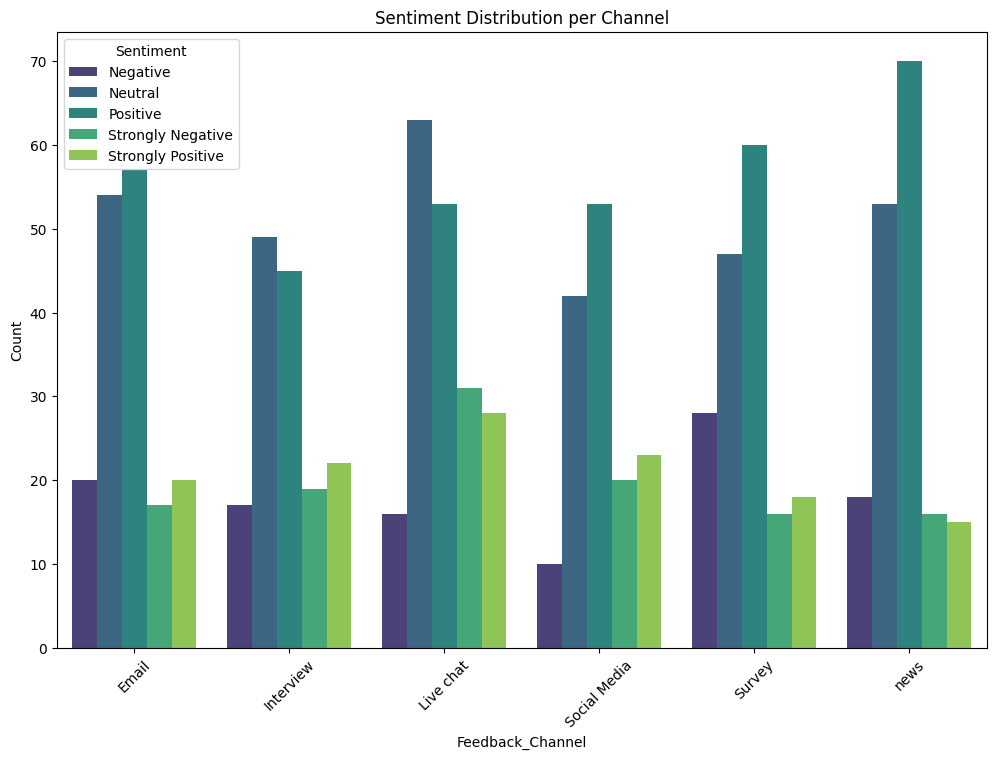

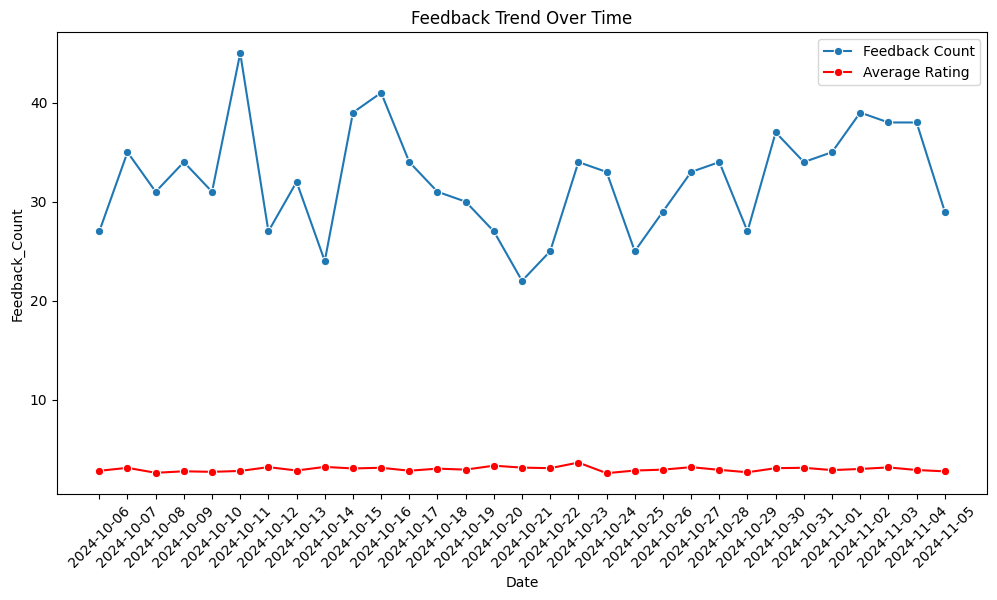

In [46]:
from pyspark.sql.functions import avg, count, col, to_timestamp, expr, date_format
import matplotlib.pyplot as plt
import seaborn as sns

def trend_analysis(spark_df):
    """Analyze feedback trends over time and by channel."""

    # Convert Date column to timestamp
    spark_df = spark_df.withColumn("Date", to_timestamp(col("Date")))

    # 1. Average ratings per channel
    avg_rating_per_channel = (
        spark_df.groupBy("Feedback_Channel")
        .agg(avg("Rating").alias("Average_Rating"))
        .orderBy("Average_Rating", ascending=False)
    )
    avg_rating_per_channel.show()

    # 2. Sentiment distribution per channel
    sentiment_distribution = (
        spark_df.groupBy("Feedback_Channel", "Sentiment")
        .agg(count("Sentiment").alias("Count"))
        .orderBy("Feedback_Channel", "Sentiment")
    )
    sentiment_distribution.show()

    # 3. Trends over time
    # Aggregate count of feedbacks and average ratings by date
    feedback_trend = (
        spark_df.groupBy(date_format("Date", "yyyy-MM-dd").alias("Date"))
        .agg(count("*").alias("Feedback_Count"), avg("Rating").alias("Average_Rating"))
        .orderBy("Date")
    )
    feedback_trend.show()

    # 4. Most Positive/Negative Channels
    # Calculate the proportion of positive and negative feedback by channel
    sentiment_proportion = (
        spark_df.groupBy("Feedback_Channel", "Sentiment")
        .agg(count("*").alias("Sentiment_Count"))
        .withColumn("Total_Feedback", expr("sum(Sentiment_Count) OVER (PARTITION BY Feedback_Channel)"))
        .withColumn("Sentiment_Proportion", col("Sentiment_Count") / col("Total_Feedback"))
        .orderBy("Feedback_Channel", "Sentiment_Proportion", ascending=False)
    )
    sentiment_proportion.show()

    # Convert DataFrames to Pandas for plotting
    avg_rating_pd = avg_rating_per_channel.toPandas()
    sentiment_dist_pd = sentiment_distribution.toPandas()
    feedback_trend_pd = feedback_trend.toPandas()
    sentiment_proportion_pd = sentiment_proportion.toPandas()

    # Plot average ratings per channel
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Feedback_Channel", y="Average_Rating", data=avg_rating_pd, palette="viridis")
    plt.title("Average Ratings per Channel")
    plt.xticks(rotation=45)
    plt.show()

    # Plot sentiment distribution per channel
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Feedback_Channel", y="Count", hue="Sentiment", data=sentiment_dist_pd, palette="viridis")
    plt.title("Sentiment Distribution per Channel")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment")
    plt.show()

    # Plot feedback trend over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Date", y="Feedback_Count", data=feedback_trend_pd, marker="o", label="Feedback Count")
    sns.lineplot(x="Date", y="Average_Rating", data=feedback_trend_pd, marker="o", label="Average Rating", color="red")
    plt.title("Feedback Trend Over Time")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    return avg_rating_per_channel, sentiment_distribution, feedback_trend, sentiment_proportion

# Execute trend analysis
avg_rating_per_channel, sentiment_distribution, feedback_trend, sentiment_proportion = trend_analysis(spark_df)


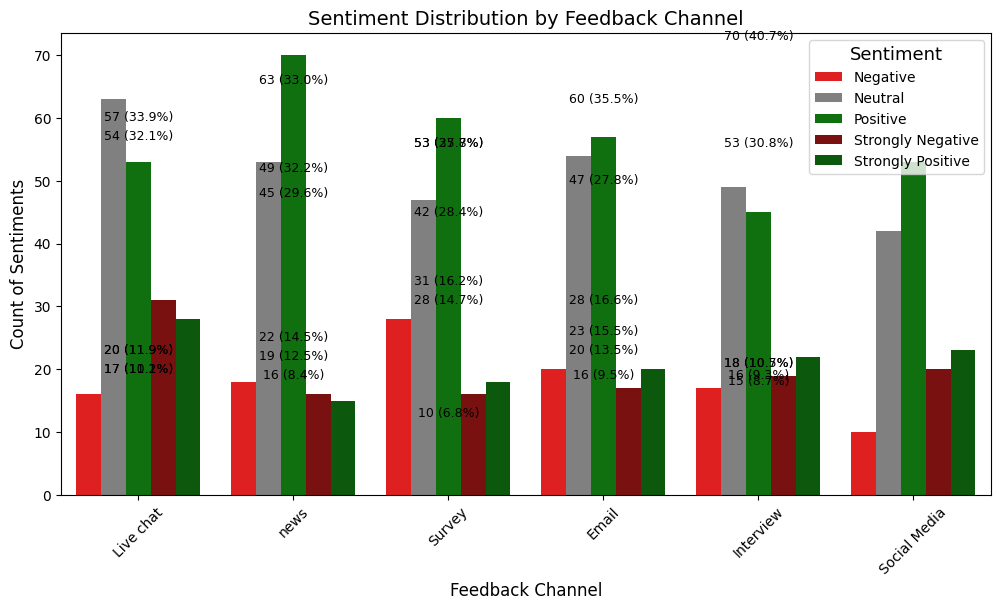

In [51]:
def visualize_sentiment_distribution(sentiment_distribution):
    """Visualize sentiment distribution by feedback channel with enhanced clarity and annotations."""
    # Convert to Pandas for easy plotting
    sentiment_pd = sentiment_distribution.toPandas()

    # Calculate total count per channel for percentage calculation
    sentiment_pd['Total_Count'] = sentiment_pd.groupby('Feedback_Channel')['Count'].transform('sum')
    sentiment_pd['Percentage'] = (sentiment_pd['Count'] / sentiment_pd['Total_Count']) * 100

    # Sort channels by total sentiment count for better readability
    sentiment_pd = sentiment_pd.sort_values('Total_Count', ascending=False)

    # Define color palette including the additional sentiment categories
    palette = {
        'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red',
        'Strongly Positive': 'darkgreen', 'Strongly Negative': 'darkred'
    }

    # Set up the figure with improved dimensions
    plt.figure(figsize=(12, 6))
    sns.set_palette("viridis")
    barplot = sns.barplot(
        x='Feedback_Channel', y='Count', hue='Sentiment', data=sentiment_pd,
        palette=palette
    )

    # Adjust text alignment for readability
    for index, row in sentiment_pd.iterrows():
        barplot.text(
            index // len(sentiment_pd['Feedback_Channel'].unique()), row['Count'] + 2,
            f"{int(row['Count'])} ({row['Percentage']:.1f}%)",
            ha='center', va='bottom', fontsize=9, color="black"
        )

    # Set title and labels
    plt.title('Sentiment Distribution by Feedback Channel', fontsize=14)
    plt.ylabel('Count of Sentiments', fontsize=12)
    plt.xlabel('Feedback Channel', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment', title_fontsize='13', loc='upper right')

    plt.show()

# Call the function to visualize sentiment distribution
visualize_sentiment_distribution(sentiment_distribution)


<ipython-input-52-fce1343bbd67>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




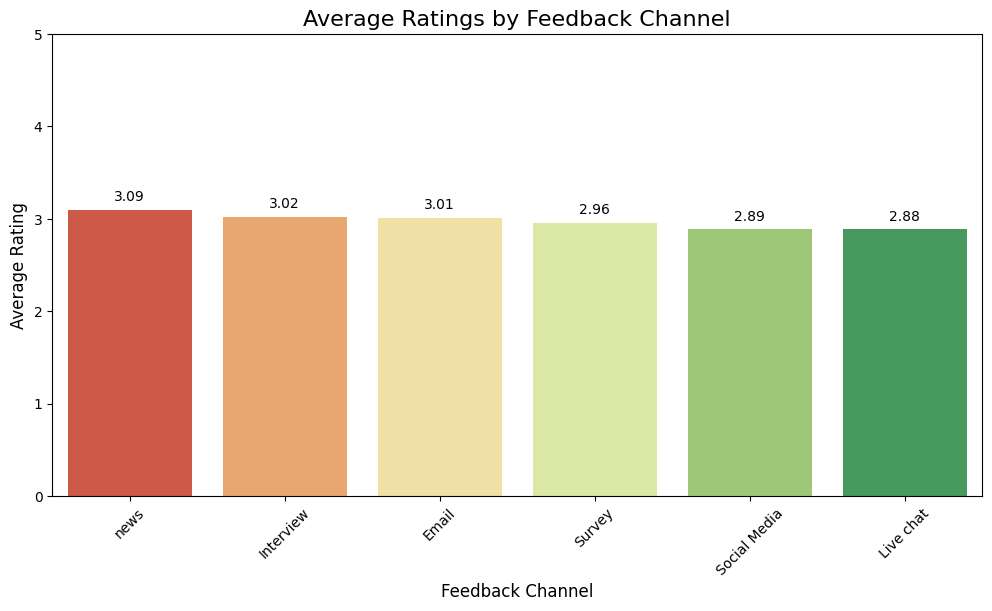

In [52]:
def visualize_average_ratings(avg_rating_per_channel):
    """Visualize average ratings by feedback channel with enhanced clarity and data labels."""
    # Convert Spark DataFrame to Pandas DataFrame
    avg_rating_pd = avg_rating_per_channel.toPandas()

    # Set up the figure with improved dimensions and color palette
    plt.figure(figsize=(12, 6))
    sns.set_palette("coolwarm")
    barplot = sns.barplot(
        x='Feedback_Channel',
        y='Average_Rating',
        data=avg_rating_pd,
        palette="RdYlGn"  # Red-Yellow-Green gradient for ratings
    )

    # Adding data labels to show average rating on each bar
    for index, row in avg_rating_pd.iterrows():
        barplot.text(
            index, row['Average_Rating'] + 0.1,
            f"{row['Average_Rating']:.2f}",
            color='black', ha="center", fontsize=10
        )

    # Set title and labels with improved font sizes
    plt.title('Average Ratings by Feedback Channel', fontsize=16)
    plt.ylabel('Average Rating', fontsize=12)
    plt.xlabel('Feedback Channel', fontsize=12)

    # Set y-axis limits to focus on rating range and improve readability
    plt.ylim(0, 5)
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

# Call the function to visualize average ratings
visualize_average_ratings(avg_rating_per_channel)


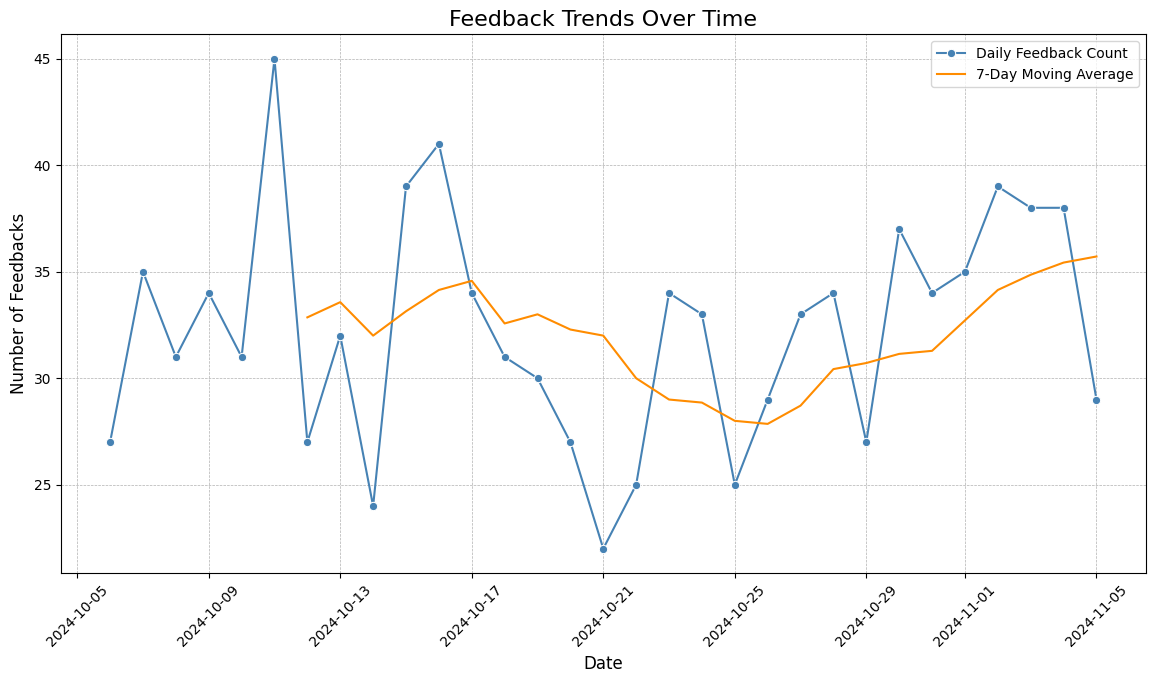

In [53]:
def visualize_trends_over_time(spark_df):
    """Visualize feedback trends over time with enhanced readability and trend smoothing."""
    # Group by date and count the number of feedbacks
    trend_data = spark_df.groupBy(F.to_date(col("Date")).alias("Date")).agg(count("Customer_ID").alias("Feedback_Count"))
    trend_data_pd = trend_data.toPandas()

    # Sort by date to ensure proper trend line order
    trend_data_pd = trend_data_pd.sort_values(by="Date")

    # Add a moving average column for trend smoothing (7-day moving average here)
    trend_data_pd['Feedback_Count_MA'] = trend_data_pd['Feedback_Count'].rolling(window=7).mean()

    # Plotting
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=trend_data_pd,
        x='Date',
        y='Feedback_Count',
        marker="o",
        color="steelblue",
        label="Daily Feedback Count"
    )

    # Plot the moving average line
    sns.lineplot(
        data=trend_data_pd,
        x='Date',
        y='Feedback_Count_MA',
        color="darkorange",
        label="7-Day Moving Average"
    )

    # Title and labels with enhanced styling
    plt.title('Feedback Trends Over Time', fontsize=16)
    plt.ylabel('Number of Feedbacks', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.xticks(rotation=45)

    # Add gridlines for easier reading
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

# Call the function to visualize trends over time
visualize_trends_over_time(spark_df)


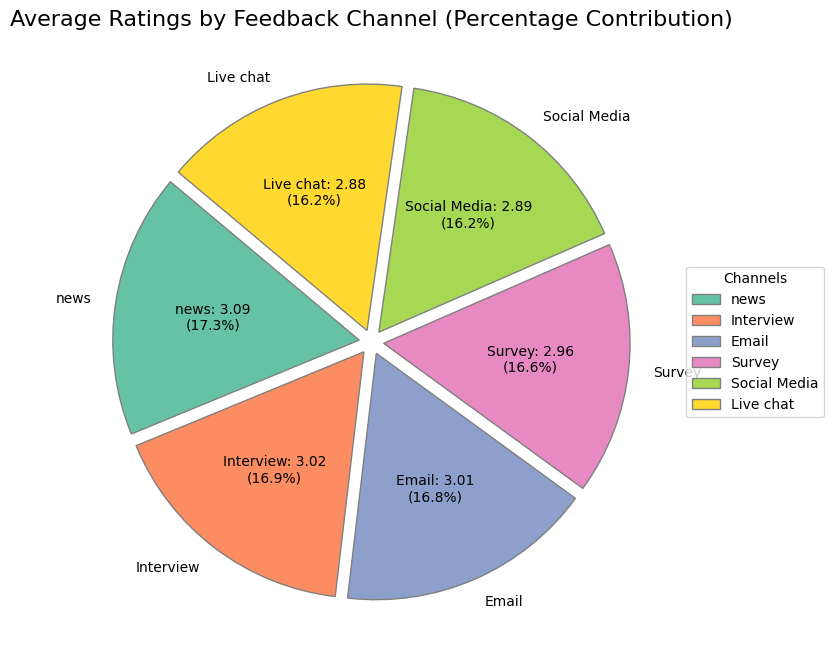

In [54]:
def visualize_average_ratings_as_pie(avg_rating_per_channel):
    """Visualize average ratings by feedback channel as an enhanced pie chart with detailed labeling."""
    # Convert to Pandas DataFrame for plotting
    avg_rating_pd = avg_rating_per_channel.toPandas()

    # Calculate percentage contribution for each channel
    avg_rating_pd['Percentage'] = (avg_rating_pd['Average_Rating'] / avg_rating_pd['Average_Rating'].sum()) * 100

    # Define colors for each channel
    colors = sns.color_palette("Set2", len(avg_rating_pd))

    # Create the pie chart
    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(
        avg_rating_pd['Percentage'],
        labels=avg_rating_pd['Feedback_Channel'],
        autopct='%1.1f%%',
        startangle=140,
        explode=[0.05] * len(avg_rating_pd),  # Slightly "explode" each slice for emphasis
        colors=colors,
        wedgeprops={'edgecolor': 'gray'}
    )

    # Add average ratings to the labels
    for i, a in enumerate(autotexts):
        a.set_text(f"{avg_rating_pd['Feedback_Channel'][i]}: {avg_rating_pd['Average_Rating'][i]:.2f}\n({avg_rating_pd['Percentage'][i]:.1f}%)")
        a.set_fontsize(10)

    # Title and legend
    plt.title('Average Ratings by Feedback Channel (Percentage Contribution)', fontsize=16)
    plt.legend(wedges, avg_rating_pd['Feedback_Channel'], title="Channels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Display the plot
    plt.show()

# Call the function to visualize average ratings as a pie chart
visualize_average_ratings_as_pie(avg_rating_per_channel)


In [57]:
import plotly.express as px

def visualize_average_ratings_as_interactive_bar(avg_rating_per_channel):
    """Visualize average ratings by feedback channel as an interactive bar chart with Plotly."""
    # Convert to Pandas DataFrame for plotting
    avg_rating_pd = avg_rating_per_channel.toPandas()

    # Create the interactive bar chart
    fig = px.bar(
        avg_rating_pd,
        x='Feedback_Channel',  # Feedback channels on x-axis
        y='Average_Rating',     # Average ratings on y-axis
        title='Average Ratings by Feedback Channel',
        text='Average_Rating',  # Display average rating on top of the bars
        labels={'Feedback_Channel': 'Channel', 'Average_Rating': 'Average Rating'},
        color='Average_Rating',  # Color bars based on average rating
        color_continuous_scale=px.colors.sequential.Viridis  # Sequential color scale
    )

    # Customize the chart layout
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')  # Format text on bars
    fig.update_layout(
        title=dict(text='Average Ratings by Feedback Channel', x=0.5),
        xaxis_title='Feedback Channels',
        yaxis_title='Average Rating',
        legend_title_text='Average Rating',
        hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"),
        yaxis=dict(range=[0, avg_rating_pd['Average_Rating'].max() + 1])  # Set y-axis range
    )

    # Show the figure
    fig.show()

# Call the function to display the interactive bar chart
visualize_average_ratings_as_interactive_bar(avg_rating_per_channel)
